# Backtesting with Zipline - Using the Pipeline API with ML-driven Signals

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
from collections import defaultdict
from time import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from logbook import Logger, StderrHandler, INFO

from zipline import run_algorithm
from zipline.api import (attach_pipeline, pipeline_output,
                         date_rules, time_rules, record,
                         schedule_function, commission, slippage,
                         set_slippage, set_commission,
                         get_open_orders, cancel_order,
                         order_target, order_target_percent)
from zipline.data import bundles
from zipline.utils.run_algo import load_extensions
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.data import Column, DataSet
from zipline.pipeline.domain import JP_EQUITIES
from zipline.pipeline.filters import StaticAssets
from zipline.pipeline.loaders.frame import DataFrameLoader

import pyfolio as pf
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe
from pyfolio.timeseries import forecast_cone_bootstrap

In [3]:
idx = pd.IndexSlice
sns.set_style('whitegrid')
np.random.seed(42)

In [4]:
results_path = Path('results', 'return_predictions')
if not results_path.exists():
    results_path.mkdir(parents=True)

### Load zipline extensions

Only need this in notebook to find bundle.

In [5]:
load_extensions(default=True,
                extensions=[],
                strict=True,
                environ=None)

In [6]:
log_handler = StderrHandler(format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                            '{record.level_name}: {record.func_name}: {record.message}',
                            level=INFO)
log_handler.push_application()
log = Logger('Algorithm')

## Algo Params

The strategy will hold the 25 stocks with the highest positive and lowest negative predictions each as long as there are at least 15 on each side.

In [7]:
N_LONGS = 25
N_SHORTS = 25
MIN_POSITIONS = 15

## Load Data

### Quandl Wiki Bundel

In [8]:
bundle_data = bundles.load('stooq')

### ML Predictions

We generate the `train` predictions in the notebook `alphalens_signal_quality` and the `test` predictions in the notebook `random_forest_return_signals`.

In [9]:
def load_predictions(bundle):
    t = 1
    df = pd.concat([pd.read_hdf(results_path / 'predictions.h5', 'train/{:02}'.format(t)),
                    pd.read_hdf(results_path / 'predictions.h5', 'test/{:02}'.format(t))])
    df = df[~df.index.duplicated()].drop('y_test', axis=1)
    predictions = df.iloc[:, :5].mean(1).to_frame('predictions')

    tickers = predictions.index.get_level_values('ticker').unique().tolist()

    assets = bundle.asset_finder.lookup_symbols(tickers, as_of_date=None)
    predicted_sids = pd.Int64Index([asset.sid for asset in assets])
    ticker_map = dict(zip(tickers, predicted_sids))

    return (predictions
            .unstack('ticker')
            .rename(columns=ticker_map)
            .predictions
            .tz_localize('UTC')), assets

In [10]:
predictions, assets = load_predictions(bundle_data)

In [11]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 504 entries, 2017-12-05 00:00:00+00:00 to 2019-12-27 00:00:00+00:00
Columns: 946 entries, 1 to 2857
dtypes: float64(946)
memory usage: 3.6 MB


### Define Custom Dataset

In [12]:
class SignalData(DataSet):
    predictions = Column(dtype=float)
    domain = JP_EQUITIES

### Define Pipeline Loaders

In [13]:
signal_loader = {SignalData.predictions:
                 DataFrameLoader(SignalData.predictions, predictions)}

## Pipeline Setup

### Custom ML Factor

In [14]:
class MLSignal(CustomFactor):
    """Converting signals to Factor
        so we can rank and filter in Pipeline"""
    inputs = [SignalData.predictions]
    window_length = 1

    def compute(self, today, assets, out, preds):
        out[:] = preds

### Create Pipeline

In [15]:
def compute_signals():
    signals = MLSignal()
    predictions = SignalData.predictions.latest
    return Pipeline(columns={
        'longs': signals.top(N_LONGS, mask=signals > 0),
        'shorts': signals.bottom(N_SHORTS, mask=signals < 0)},
        screen=StaticAssets(assets)
    )

## Initialize Algorithm

In [16]:
def initialize(context):
    """
    Called once at the start of the algorithm.
    """
    context.n_longs = N_LONGS
    context.n_shorts = N_SHORTS
    context.min_positions = MIN_POSITIONS
    context.universe = assets
    context.trades = pd.Series()

    set_slippage(slippage.FixedSlippage(spread=0.00))
    set_commission(commission.PerShare(cost=0.05, min_trade_cost=1))

    schedule_function(rebalance,
                      date_rules.every_day(),
                      time_rules.market_open(hours=1, minutes=30))

    schedule_function(record_vars,
                      date_rules.every_day(),
                      time_rules.market_close())

    pipeline = compute_signals()
    attach_pipeline(pipeline, 'signals')

### Get daily Pipeline results

In [17]:
def before_trading_start(context, data):
    """
    Called every day before market open.
    """
    output = pipeline_output('signals')
    context.trades = (output['longs'].astype(int)
                      .append(output['shorts'].astype(int).mul(-1))
                      .reset_index()
                      .drop_duplicates()
                      .set_index('index')
                      .squeeze())

## Define Rebalancing Logic

In [18]:
def rebalance(context, data):
    """
    Execute orders according to schedule_function() date & time rules.
    """
    trades = defaultdict(list)
    for symbol, open_orders in get_open_orders().items():
        for open_order in open_orders:
            cancel_order(open_order)

    positions = context.portfolio.positions
    s = (pd.Series({s: v.amount*v.last_sale_price for s,
                    v in positions.items()})
         .sort_values(ascending=False))
    
    for stock, trade in context.trades.items():
        if trade == 0:
            order_target(stock, target=0)
        else:
            trades[trade].append(stock)

    context.longs, context.shorts = len(trades[1]), len(trades[-1])
    if context.longs > context.min_positions and context.shorts > context.min_positions:
        for stock in trades[-1]:
            order_target_percent(stock, -1 / context.shorts)
        for stock in trades[1]:
            order_target_percent(stock, 1 / context.longs)
    else:
        for stock in trades[-1] + trades[1]:
            if stock in positions:
                order_target(stock, 0)

## Record Data Points

In [19]:
def record_vars(context, data):
    """
    Plot variables at the end of each day.
    """
    record(leverage=context.account.leverage,
           longs=context.longs,
           shorts=context.shorts)

## Run Algorithm

In [20]:
dates = predictions.index.get_level_values('date')
start_date = dates.min() + pd.DateOffset(day=1)
end_date = dates.max()

In [21]:
print('Start:\t{}\nEnd:\t{}'.format(start_date.date(), end_date.date()))

Start:	2017-12-01
End:	2019-12-27


In [22]:
start = time()
results = run_algorithm(start=start_date,
                        end=end_date,
                        initialize=initialize,
                        before_trading_start=before_trading_start,
                        capital_base=1e6,
                        data_frequency='daily',
                        bundle='stooq',
                        custom_loader=signal_loader)# need to modify zipline

print('Duration: {:.2f}s'.format(time() - start))

[2021-04-16 00:45:11.957893]: INFO: handle_simulation_end: Simulated 521 trading days
first open: 2017-12-01 14:31:00+00:00
last close: 2019-12-27 21:00:00+00:00


Duration: 19.67s


## PyFolio Analysis

In [23]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

In [27]:
benchmark = web.DataReader('NIKKEI225', 
                           'fred', 
                           start='2015', 
                           end='2020').squeeze()
benchmark = benchmark.pct_change().tz_localize('UTC')

### Custom Plots

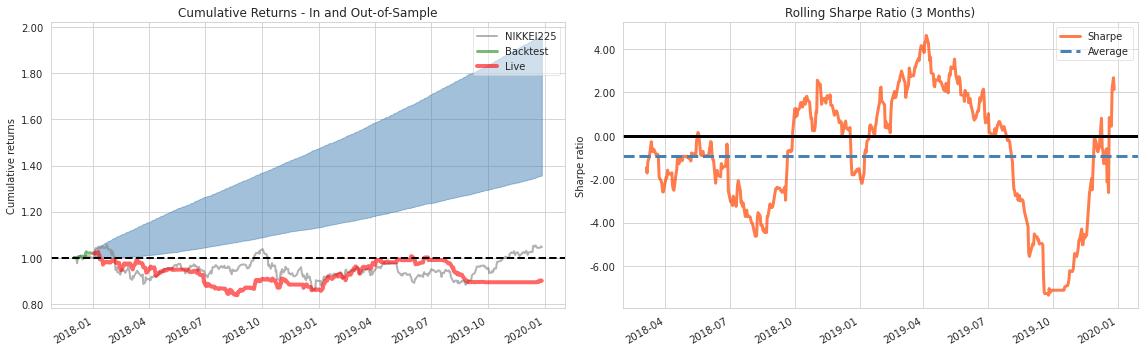

In [25]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
plot_rolling_returns(returns,
                     factor_returns=benchmark,
                     live_start_date='2018-01-01',
                     logy=False,
                     cone_std=2,
                     legend_loc='best',
                     volatility_match=False,
                     cone_function=forecast_cone_bootstrap,
                    ax=axes[0])
plot_rolling_sharpe(returns, ax=axes[1], rolling_window=63)
axes[0].set_title('Cumulative Returns - In and Out-of-Sample')
axes[1].set_title('Rolling Sharpe Ratio (3 Months)')
fig.tight_layout()
fig.savefig((results_path / 'pyfolio_out_of_sample').as_posix(), dpi=300);

### Tear Sheets

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,18.37,2017-12-21,2018-08-22,NaT,NaN
1,0.18,2017-12-12,2017-12-13,2017-12-14,3
2,0.14,2017-12-14,2017-12-19,2017-12-20,5
3,0.13,2017-12-08,2017-12-11,2017-12-12,3
4,0.01,2017-12-06,2017-12-07,2017-12-08,3


Stress Events,mean,min,max
New Normal,-0.02%,-2.68%,2.91%


Top 10 long positions of all time,max
sid,
4078.JP,21.59%
6753.JP,17.79%
8558.JP,17.28%
6779.JP,16.40%
7013.JP,15.17%
4331.JP,14.44%
9507.JP,13.25%
6445.JP,12.74%
6905.JP,12.70%


Top 10 short positions of all time,max
sid,
6779.JP,-16.06%
4078.JP,-15.41%
9507.JP,-13.45%
8107.JP,-12.96%
4331.JP,-12.84%
6445.JP,-12.57%
8515.JP,-12.36%
8558.JP,-11.93%
7280.JP,-11.77%


Top 10 positions of all time,max
sid,
4078.JP,21.59%
6753.JP,17.79%
8558.JP,17.28%
6779.JP,16.40%
7013.JP,15.17%
4331.JP,14.44%
9507.JP,13.45%
8107.JP,12.96%
6445.JP,12.74%


Summary stats,All trades,Short trades,Long trades
Total number of round_trips,8991.00,4672.00,4319.00
Percent profitable,0.48,0.48,0.48
Winning round_trips,4292.00,2230.00,2062.00
Losing round_trips,4366.00,2255.00,2111.00
Even round_trips,333.00,187.00,146.00


PnL stats,All trades,Short trades,Long trades
Total profit,$-41077.72,$-89775.06,$48697.34
Gross profit,$2988669.98,$1373589.94,$1615080.04
Gross loss,$-3029747.70,$-1463365.00,$-1566382.70
Profit factor,$0.99,$0.94,$1.03
Avg. trade net profit,$-4.57,$-19.22,$11.28
Avg. winning trade,$696.34,$615.96,$783.26
Avg. losing trade,$-693.94,$-648.94,$-742.01
Ratio Avg. Win:Avg. Loss,$1.00,$0.95,$1.06
Largest winning trade,$15236.00,$5292.00,$15236.00
Largest losing trade,$-15759.45,$-15759.45,$-12394.80


Duration stats,All trades,Short trades,Long trades
Avg duration,1 days 19:20:18.018018018,1 days 18:47:11.763698630,1 days 19:56:06.612641815
Median duration,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00
Longest duration,12 days 00:00:00,12 days 00:00:00,12 days 00:00:00
Shortest duration,0 days 21:00:00,0 days 21:00:00,0 days 21:00:00


Return stats,All trades,Short trades,Long trades
Avg returns all round_trips,-0.00%,-0.00%,0.00%
Avg returns winning,0.07%,0.07%,0.08%
Avg returns losing,-0.07%,-0.07%,-0.07%
Median returns all round_trips,0.00%,0.00%,0.00%
Median returns winning,0.05%,0.05%,0.05%
Median returns losing,-0.05%,-0.05%,-0.05%
Largest winning trade,1.79%,1.39%,1.79%
Largest losing trade,-1.71%,-0.87%,-1.71%


Symbol stats,1332.JP,1377.JP,1379.JP,1407.JP,1414.JP,1515.JP,1518.JP,1605.JP,1662.JP,1719.JP,1721.JP,1766.JP,1801.JP,1802.JP,1803.JP,1805.JP,1808.JP,1812.JP,1820.JP,1821.JP,1824.JP,1833.JP,1835.JP,1852.JP,1860.JP,1861.JP,1871.JP,1873.JP,1878.JP,1881.JP,1883.JP,1884.JP,1885.JP,1893.JP,1911.JP,1925.JP,1926.JP,1928.JP,1941.JP,1942.JP,1944.JP,1949.JP,1950.JP,1951.JP,1954.JP,1959.JP,1961.JP,1963.JP,1968.JP,1969.JP,1979.JP,2002.JP,2109.JP,2120.JP,2127.JP,2146.JP,2151.JP,2157.JP,2168.JP,2174.JP,2175.JP,2181.JP,2191.JP,2193.JP,2201.JP,2206.JP,2211.JP,2212.JP,2220.JP,2264.JP,2267.JP,2269.JP,2270.JP,2281.JP,2282.JP,2305.JP,2317.JP,2327.JP,2331.JP,2353.JP,2362.JP,2370.JP,2371.JP,2379.JP,2389.JP,2398.JP,2412.JP,2413.JP,2428.JP,2429.JP,2432.JP,2433.JP,2440.JP,2461.JP,2491.JP,2492.JP,2501.JP,2502.JP,2503.JP,2531.JP,2579.JP,2590.JP,2593.JP,2602.JP,2607.JP,2651.JP,2659.JP,2664.JP,2670.JP,2678.JP,2681.JP,2685.JP,2695.JP,2702.JP,2706.JP,2726.JP,2730.JP,2749.JP,2767.JP,2768.JP,2782.JP,2784.JP,2792.JP,2801.JP,2802.JP,2809.JP,2810.JP,2811.JP,2815.JP,2871.JP,2874.JP,2875.JP,2897.JP,2910.JP,2914.JP,2918.JP,3002.JP,3003.JP,3028.JP,3036.JP,3038.JP,3048.JP,3050.JP,3064.JP,3076.JP,3086.JP,3087.JP,3088.JP,3092.JP,3097.JP,3098.JP,3099.JP,3101.JP,3103.JP,3104.JP,3105.JP,3106.JP,3107.JP,3109.JP,3110.JP,3116.JP,3141.JP,3148.JP,3156.JP,3201.JP,3231.JP,3244.JP,3254.JP,3258.JP,3315.JP,3333.JP,3341.JP,3349.JP,3360.JP,3382.JP,3387.JP,3391.JP,3395.JP,3397.JP,3401.JP,3402.JP,3405.JP,3431.JP,3433.JP,3436.JP,3569.JP,3591.JP,3593.JP,3626.JP,3632.JP,3635.JP,3738.JP,3762.JP,3769.JP,3774.JP,3857.JP,3861.JP,3864.JP,3865.JP,3880.JP,3941.JP,4004.JP,4005.JP,4008.JP,4021.JP,4023.JP,4028.JP,4041.JP,4042.JP,4043.JP,4044.JP,4045.JP,4047.JP,4061.JP,4062.JP,4063.JP,4064.JP,4078.JP,4088.JP,4091.JP,4092.JP,4100.JP,4109.JP,4112.JP,4114.JP,4118.JP,4151.JP,4183.JP,4185.JP,4186.JP,4188.JP,4202.JP,4203.JP,4204.JP,4205.JP,4206.JP,4208.JP,4217.JP,4272.JP,4282.JP,4293.JP,4301.JP,4307.JP,4324.JP,4331.JP,4343.JP,4348.JP,4401.JP,4403.JP,4452.JP,4471.JP,4502.JP,4503.JP,4506.JP,4514.JP,4516.JP,4519.JP,4521.JP,4523.JP,4527.JP,4528.JP,4530.JP,4534.JP,4536.JP,4540.JP,4541.JP,4543.JP,4544.JP,4547.JP,4548.JP,4549.JP,4551.JP,4553.JP,4555.JP,4559.JP,4565.JP,4568.JP,4569.JP,4574.JP,4612.JP,4613.JP,4617.JP,4626.JP,4631.JP,4633.JP,4634.JP,4661.JP,4665.JP,4666.JP,4668.JP,4676.JP,4680.JP,4681.JP,4684.JP,4686.JP,4689.JP,4694.JP,4704.JP,4708.JP,4714.JP,4716.JP,4732.JP,4733.JP,4739.JP,4751.JP,4755.JP,4768.JP,4812.JP,4813.JP,4819.JP,4825.JP,4849.JP,4901.JP,4902.JP,4911.JP,4912.JP,4917.JP,4919.JP,4921.JP,4922.JP,4967.JP,4971.JP,4975.JP,4985.JP,4996.JP,4997.JP,5017.JP,5019.JP,5101.JP,5108.JP,5110.JP,5186.JP,5191.JP,5201.JP,5202.JP,5208.JP,5214.JP,5232.JP,5233.JP,5301.JP,5302.JP,5310.JP,5331.JP,5332.JP,5333.JP,5334.JP,5344.JP,5352.JP,5384.JP,5393.JP,5401.JP,5406.JP,5410.JP,5411.JP,5423.JP,5440.JP,5444.JP,5451.JP,5463.JP,5471.JP,5480.JP,5481.JP,5482.JP,5486.JP,5541.JP,5563.JP,5602.JP,5631.JP,5632.JP,5706.JP,5707.JP,5711.JP,5713.JP,5714.JP,5715.JP,5726.JP,5727.JP,5741.JP,5801.JP,5803.JP,5805.JP,5809.JP,5851.JP,5852.JP,5857.JP,5901.JP,5911.JP,5929.JP,5930.JP,5943.JP,5947.JP,5949.JP,5959.JP,5970.JP,5975.JP,5981.JP,5988.JP,5991.JP,6005.JP,6013.JP,6101.JP,6103.JP,6104.JP,6113.JP,6118.JP,6135.JP,6136.JP,6140.JP,6141.JP,6143.JP,6145.JP,6146.JP,6201.JP,6222.JP,6250.JP,6255.JP,6268.JP,6269.JP,6273.JP,6277.JP,6278.JP,6282.JP,6287.JP,6301.JP,6302.JP,6305.JP,6310.JP,6315.JP,6324.JP,6326.JP,6330.JP,6339.JP,6349.JP,6361.JP,6363.JP,6366.JP,6367.JP,6369.JP,6370.JP,6371.JP,6376.JP,6379.JP,6383.JP,6390.JP,6395.JP,6406.JP,6407.JP,6409.JP,6412.JP,6413.JP,6417.JP,6418.JP,6420.JP,6425.JP,6432.JP,6436.JP,6440.JP,6444.JP,6445.JP,6448.JP,6457.JP,6460.JP,6461.JP,6462.JP,6463.JP,6465.JP,6471.JP,6472.JP,6473.JP,6474.JP,6479.JP,6480.JP,6481.JP,6486.JP,6498.JP,6502.JP,6503.JP,6504.JP,6506.JP,6507.JP,6508.JP,6516.JP,6586.JP,6588.JP,6592.JP,6594.JP,6622.JP,6632.JP,6640.JP,6641.JP,6644.JP,6645.JP,6651.JP,6674.JP,6701.JP,6702.JP,6703.JP,6706.JP,670

Profitability (PnL / PnL total) per name,
symbol,
4078.JP,95.26%
6753.JP,50.59%
4293.JP,40.99%
6255.JP,34.79%
7014.JP,34.58%
3038.JP,28.62%
8237.JP,28.41%
6445.JP,28.08%
3436.JP,24.85%


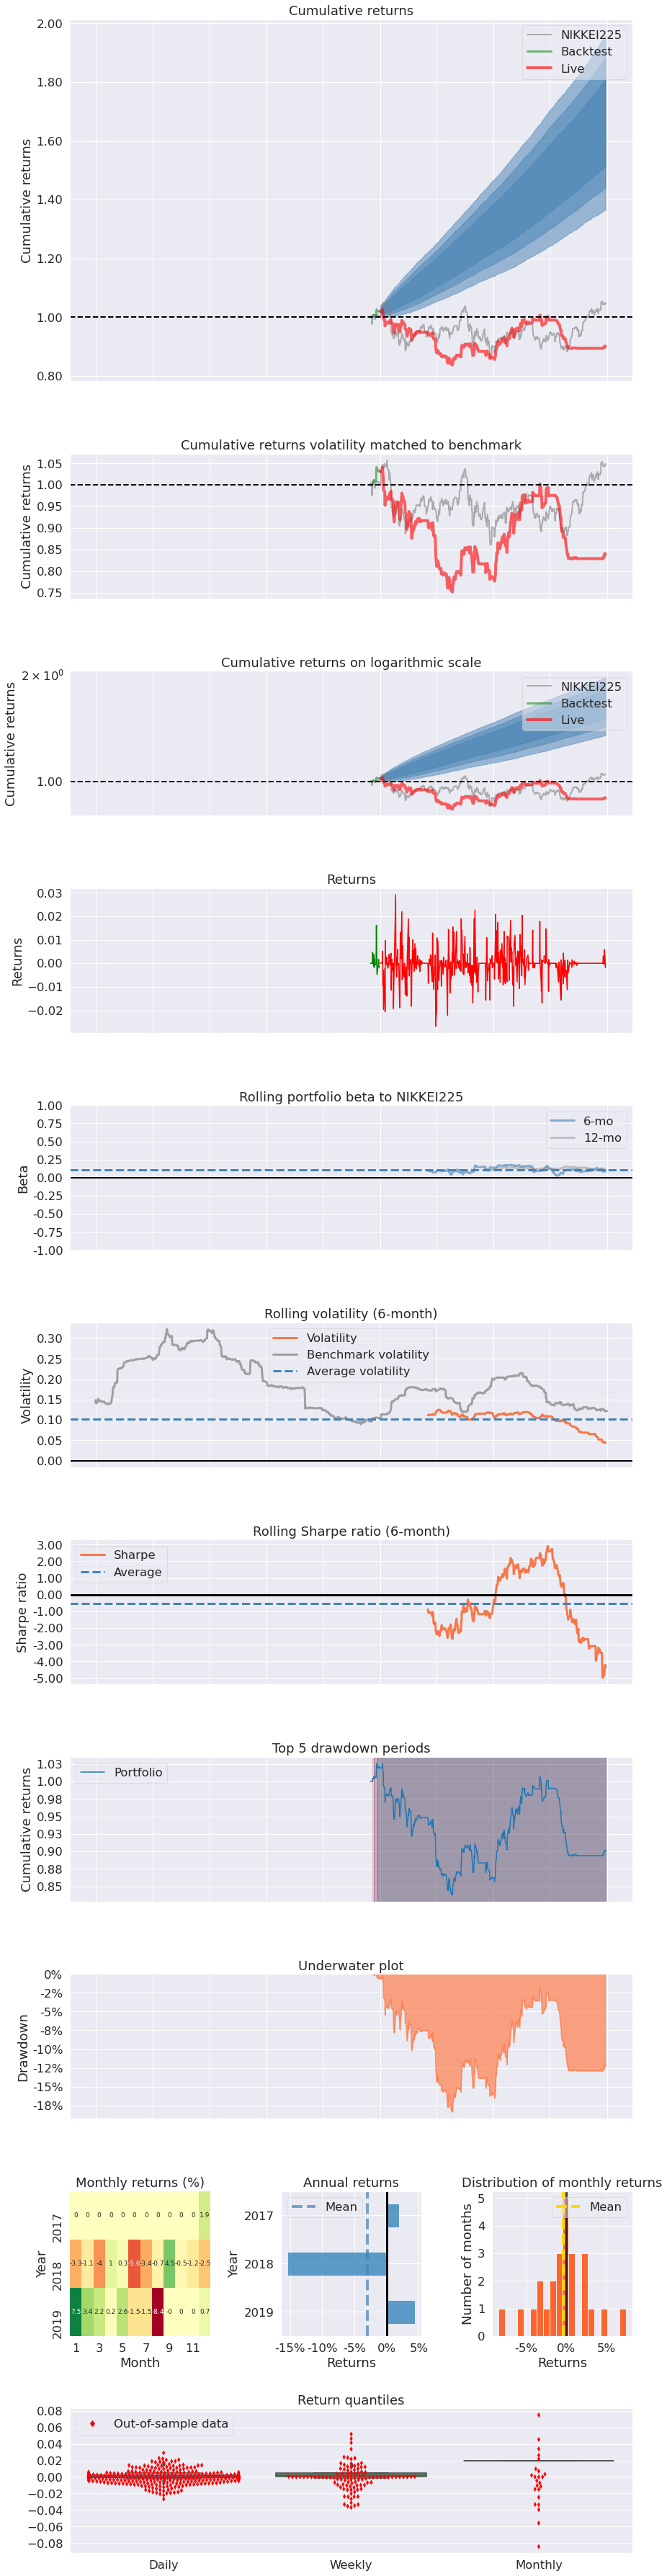

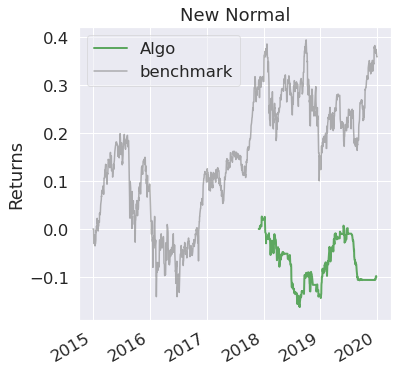

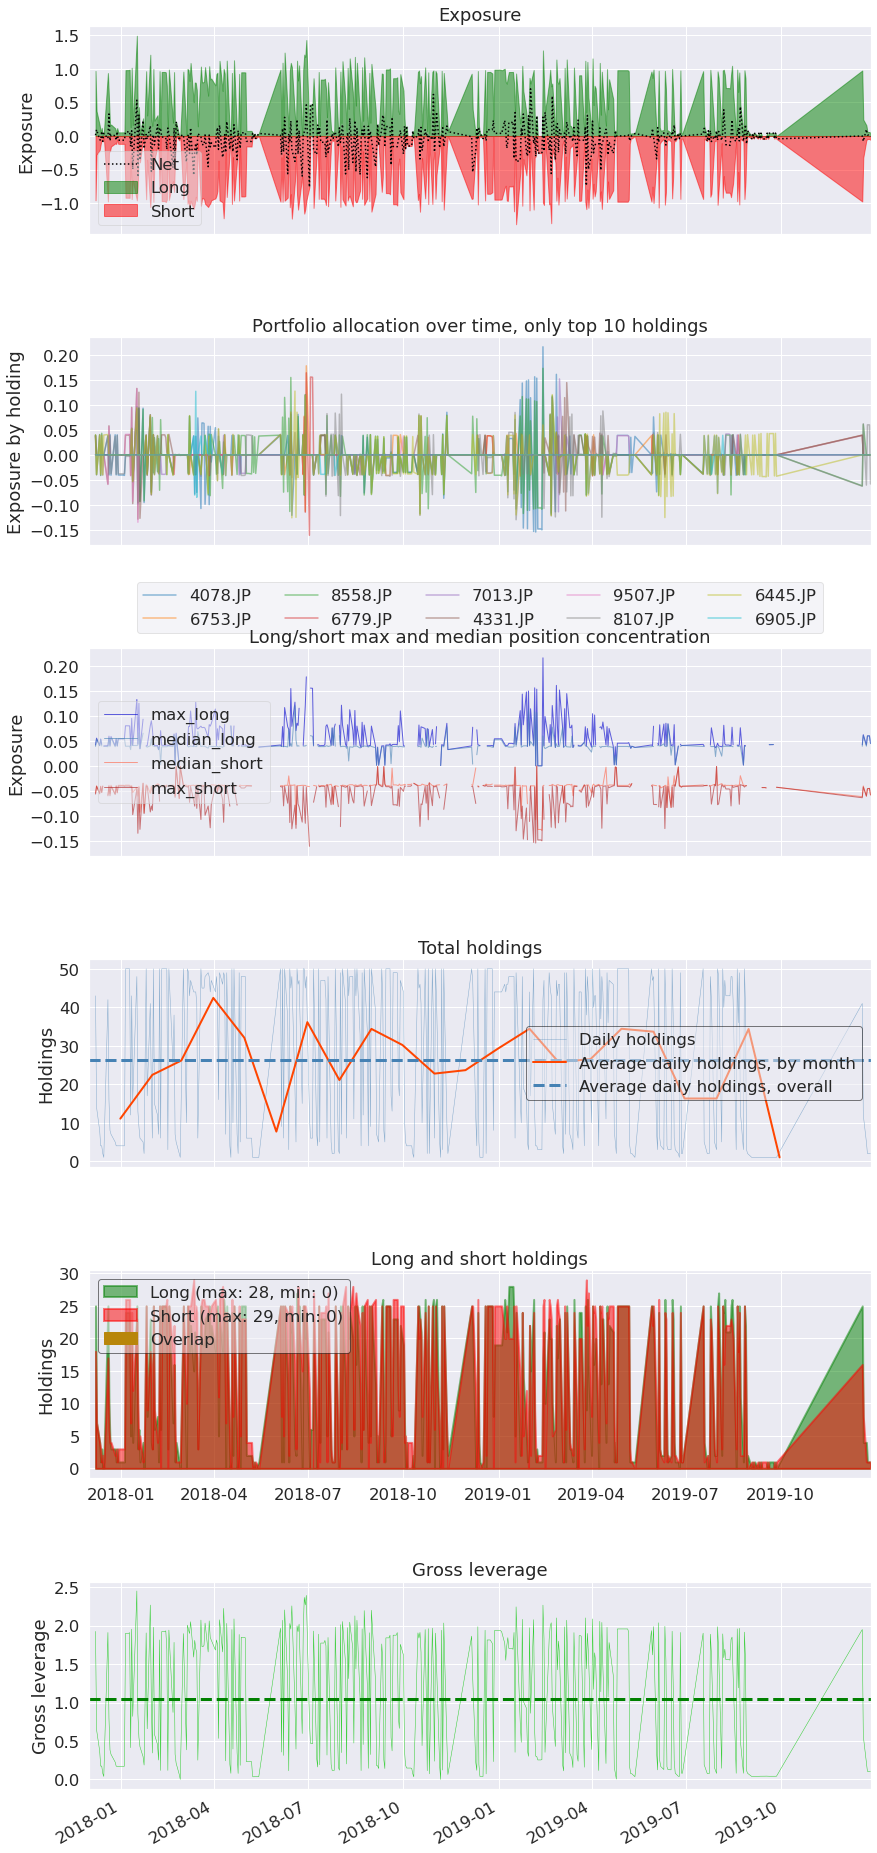

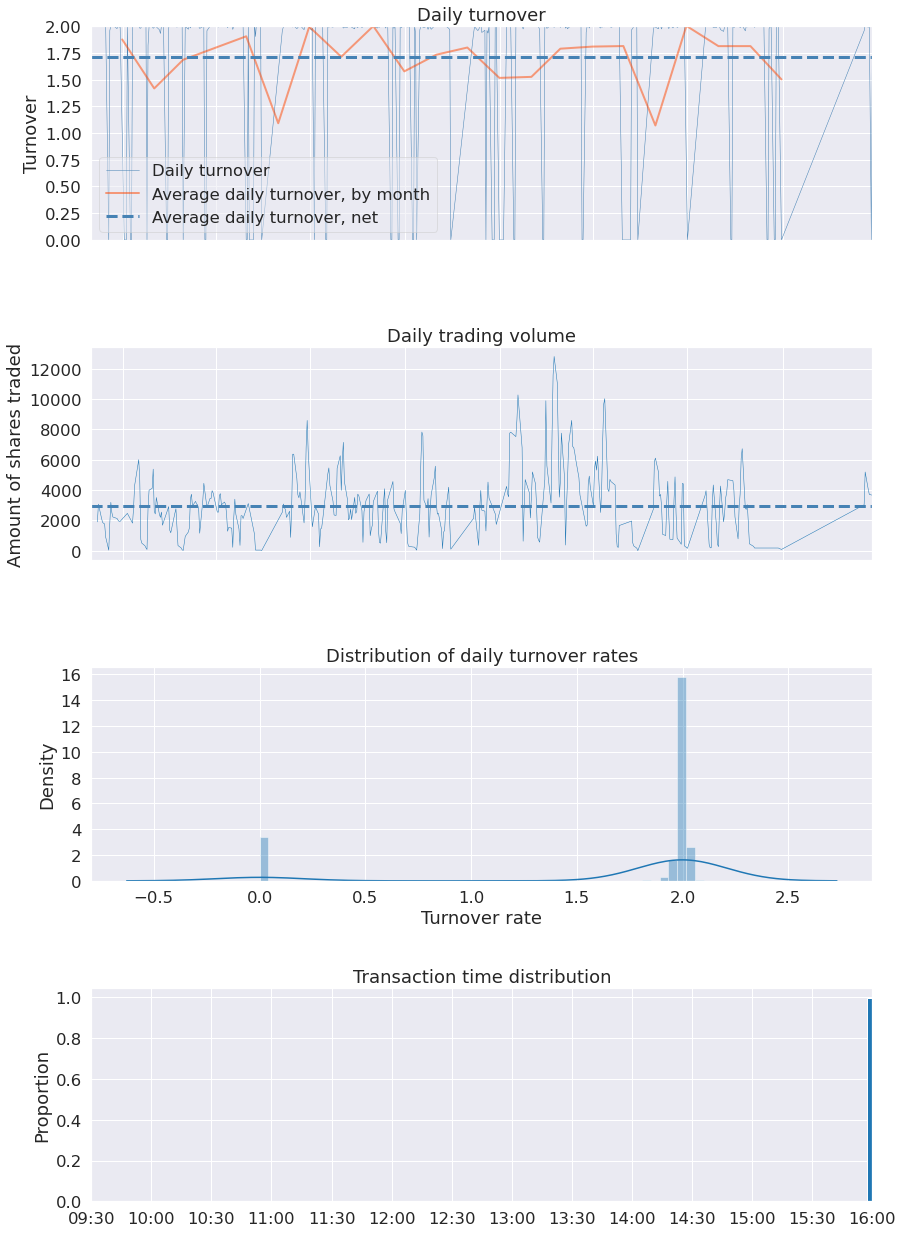

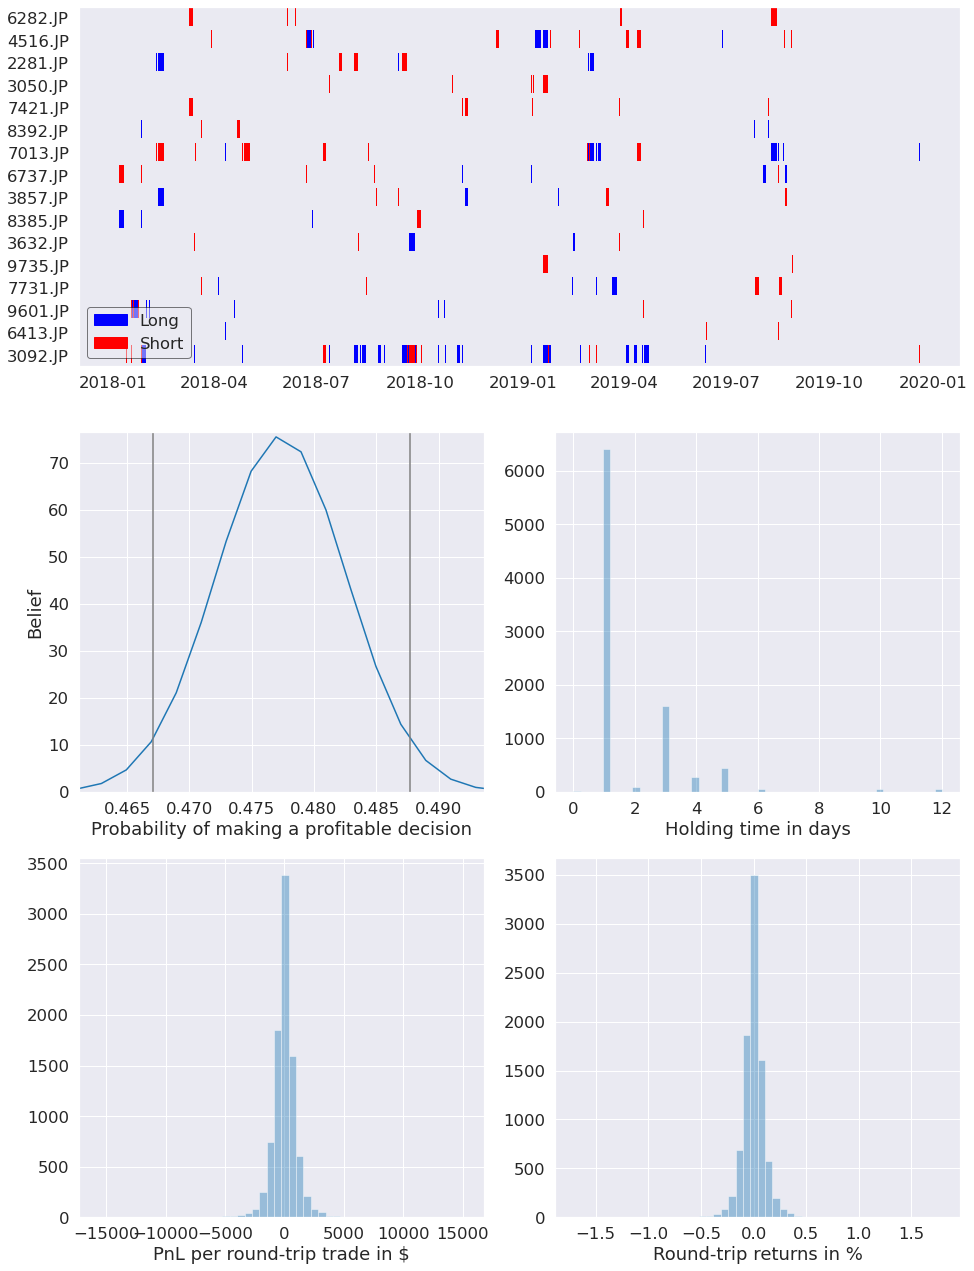

In [26]:
pf.create_full_tear_sheet(returns, 
                          positions=positions, 
                          transactions=transactions,
                          benchmark_rets=benchmark,
                          live_start_date='2018-01-01', 
                          round_trips=True)